<h3>U204N3294</h3>
<h3>Charalambos Kyprianou </h4>
<h3>COMP-548DL - Big Data Management and Processing - Final Project</h3>
<h3>--------------------------------------------------------------------------------------------------------------------------</h3>
<h4>Introduction</h4>
<h5>This project aims, by collecting and analyzing various text reviews of banks and bank services, to provide insights on which areas of these services are positively adopted by the customers and which areas require improvments. The purpose, is not provide solutions to the problems or to the complaiments of the customers , neither to predict the adoptability of a new feature by the customers. The purpose is to show that is feasible by analyzing the reviews of a service or application, in our case for the ebanking sector, to extract some topics that are worth being reviewed by the bank to shed some light on the areas of those services or the application that the customer is satisfied with or that require urgent improvments to improve their customer satisfaction and experience.<br><br>
The challenge in this project is both Veracity and Variety. This is due to that we have various datasets with various data (ratings, reviews, banks) that we have to process and clean them. The reviews data are unstructured and incosistent. Some reviews are in english and some in other languages, even in emoji language. So the data should be cleaned, translated, normalized and unified into a format that can be processed. <br> Additionaly the reviews might not be trustworthy concerning the rating score. For example, the customers might give a good rating but include bad comments in the review or vice verca. So we use an extra rating score. <br><br>
To decide whether a review is bad or good we use the rating score of each review given by the user along with a positive-negative score given with an algorithm by processing the context of the review.<br><br>
Various datasets were used for this project for various banks wordwide. At first, the challenge was to transform all these various datasets and combine them into a single dataset of a unified structure and schema. The finalized dataset is stored in a Cassandra DB of Astra, accessed by Google Cloud. The reason for choosing the Cassandra DB is because our data require a simple schema but that could easily change, like adding different rating scale, bigger reviews or add more columns. Also the high write throughput of NOSQL databases is a plus.</h5>

<h5><i><b>Note:</b>To run this project you should have installed:<br>
- Python 3.8 <br>
- Jupyter Notebook <br>
- Cassandra dependencies</i></h5>

<h4>Part 1: Data Pre-processing & Storage</h4>
<h5>Firstly lets connect to the Cassandra Database and create the table needed to store our data.</h5>

In [6]:
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider
import json

# This secure connect bundle is autogenerated when you download your SCB, 
# if yours is different update the file name below
cloud_config= {
  'secure_connect_bundle': 'secure-connect-comp-548dl.zip'
}

# This token JSON file is autogenerated when you download your token, 
# if yours is different update the file name below
with open("COMP-548DL-token.json") as f:
    secrets = json.load(f)

CLIENT_ID = secrets["clientId"]
CLIENT_SECRET = secrets["secret"]

auth_provider = PlainTextAuthProvider(CLIENT_ID, CLIENT_SECRET)
cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider)
session = cluster.connect()

row = session.execute("select release_version from system.local").one()
if row:
  print(row[0])
else:
  print("An error occurred.")

4.0.11-c44bc828c0c8


In [34]:
session.set_keyspace('comp548dl')

# Create the table
session.execute("""
    CREATE TABLE IF NOT EXISTS BankReviews (
        id TEXT PRIMARY KEY,
        date TIMESTAMP,
        bank TEXT,
        rating DOUBLE,
        review TEXT
    )
""")



<h5>Let's check that the table has been created successfuly.</h5>

In [35]:
rows = session.execute("SELECT table_name FROM system_schema.tables WHERE keyspace_name = %s", ('comp548dl',))

# Print the table names
for row in rows:
    print(row[0])


bankreviews


<h5>Next, lets pre-process our various datasets and transform them into a unified structure that fits our table. We will also perform some data cleaning by droping the empty or null reviews and normalize them.</h5>
<h5>Dataset 1</h5>

In [18]:
import pandas as pd
from pandas_gbq import schema
import uuid

file_path = 'Datasets/bank_reviews3.csv'
df1 = pd.read_csv(file_path)

#We drop the columns that are of no use.
columns_to_drop = ['author', 'address', 'review_title_by_user', 'bank_image', 'rating_title_by_user', 'useful_count']
df1.drop(columns=columns_to_drop, inplace=True)

new_column_names = ['date', 'bank', 'rating', 'review']
df1.columns = new_column_names

df1['date'] = pd.to_datetime(df1['date'], format='%b %d, %Y', errors='coerce')
df1['date'] = df1['date'].dt.strftime('%d-%m-%Y')
df1['date'] = pd.to_datetime(df1['date'], dayfirst=True)
df1['bank'] = df1['bank'].replace('review', 'Unlabeled')

df1['review'] = df1['review'].str.strip()
df1 = df1[df1['review'].notna() & (df1['review'] != '')]

print(df1.head())

        date       bank  rating  \
0 2020-03-21        SBI     4.0   
1 2020-03-20        SBI     5.0   
2 2020-03-20  Axis Bank     5.0   
3 2020-03-20  HDFC Bank     5.0   
4 2020-03-20  Unlabeled     5.0   

                                              review  
0  State Bank Of India is located nearby in our a...  
1  I have my salary account in SBI, when I applie...  
2  I am using Axis bank saving account for the  p...  
3  I have my salary bank account in HDFC bank for...  
4  Close to around 10 years, I am holding this Co...  


<h5>Dataset 2</h5>

In [19]:
file_path = 'Datasets/BankReviews.csv'
df2 = pd.read_csv(file_path, encoding='ISO-8859-1')

new_column_names = ['date', 'rating', 'review', 'bank']
df2.columns = new_column_names

desired_column_order = ['date', 'bank', 'rating', 'review']
df2 = df2[desired_column_order]
df2['bank'] = df2['bank'].replace('review', 'Unlabeled')


df2['review'] = df2['review'].str.strip()
df2 = df2[df2['review'].notna() & (df2['review'] != '')]

df2['date'] = pd.to_datetime(df2['date'], dayfirst=True)

print(df2.head())

        date                      bank  rating  \
0 2017-04-10  Wyndham Capital Mortgage       5   
1 2017-02-10  Wyndham Capital Mortgage       5   
2 2017-08-21  Wyndham Capital Mortgage       5   
3 2017-12-17  Wyndham Capital Mortgage       5   
4 2016-05-27  Wyndham Capital Mortgage       5   

                                              review  
0  Great job, Wyndham Capital! Each person was pr...  
1  Matthew Richardson is professional and helpful...  
2  We had a past experience with Wyndham Mortgage...  
3  We have been dealing with Brad Thomka from the...  
4  I can't express how grateful I am for the supp...  


<h5>Dataset 3 <br><br>
This dataset required to be translated into English since it was in Russian. So the following code was used to translate the reviews, and export them into a new csv. This code snipet is commented out since it takes a long time to run. The finalized exported csv file was used.</h5>

In [21]:
from langdetect import detect
file_path = 'Datasets/translated_data.csv'
df3 = pd.read_csv(file_path)

#Method to check the translated text language. We keep only those in english. 
def detect_language(text):
    try:
        if pd.notnull(text) and len(str(text)) > 3:
            return detect(text)
        else:
            return None
    except Exception as e:
        return None

df3['review'] = df3['review'].str.strip()
df3 = df3[df3['review'].notna() & (df3['review'] != '')]
df3['detected_language'] = df3['translated_review'].apply(detect_language)

# Display the DataFrame with the detected language
df3 = df3[df3['detected_language']=='en']

columns_to_drop = ['Unnamed: 0', 'title', 'userName', 'review', 'isEdited', 'developerResponse', 'detected_language']
df3.drop(columns=columns_to_drop, inplace=True)
df3['bank'] = 'Sberbank of Russia'

new_column_names = ['rating', 'date', 'review', 'bank']
df3.columns = new_column_names

desired_column_order = ['date', 'bank', 'rating', 'review']
df3 = df3[desired_column_order]

print(df3)

                     date                bank  rating  \
0     2017-04-25 06:53:10  Sberbank of Russia       5   
1     2019-01-12 07:52:02  Sberbank of Russia       1   
2     2020-05-31 16:32:19  Sberbank of Russia       1   
3     2019-08-27 15:39:14  Sberbank of Russia       1   
4     2018-10-27 17:27:52  Sberbank of Russia       1   
...                   ...                 ...     ...   
7535  2021-10-29 09:07:40  Sberbank of Russia       5   
7536  2021-10-29 09:27:01  Sberbank of Russia       2   
7537  2021-10-29 09:17:49  Sberbank of Russia       1   
7538  2021-10-29 08:51:54  Sberbank of Russia       3   
7539  2021-10-29 07:56:11  Sberbank of Russia       3   

                                                 review  
0     I am very pleased. I can’t even think of any d...  
1     Stop blocking the application and loading it w...  
2     You are such a disgusting bank that you haven’...  
3     What kind of nonsense is the commission for a ...  
4     Remove all those du

<h5>Now that each of our datasets are cleaned and unified, lets combine them into a single dataset and store them into the Database. This part of the project can be done separately to add new data to our database whenever possible or necessary. But since part of the project was to find data and perform some pre-processing, we include this part in the notebook as well. Additional data can be pre-processed in the same way to fit the DB schema and added in the database to perform the analytics. Ideally, in reality, a bank would have a timer inserting the new reviews in the Cassandra dabase daily.</h5>

In [29]:
def generate_uuid(row):
    return str(uuid.uuid4())
    
result_df = pd.concat([df1, df2, df3], axis=0, ignore_index=True)
result_df['id'] = result_df.apply(generate_uuid, axis=1)
desired_column_order = ['id', 'date', 'bank', 'rating', 'review']
result_df = result_df[desired_column_order]
result_df['date'] = pd.to_datetime(result_df['date'])

print(result_df)
#result_df.to_csv('result.csv', index=False)

                                        id                date  \
0     2b99570b-cfca-41cc-9f2e-dd09f80c5243 2020-03-21 00:00:00   
1     e0f69146-8405-4c98-bdd7-64b0673007a3 2020-03-20 00:00:00   
2     467214e4-7c42-4042-9c1e-5a703c65fb25 2020-03-20 00:00:00   
3     204b9467-7e03-46f9-b0a2-4a4f3d321e37 2020-03-20 00:00:00   
4     84ee5605-106c-49c8-92e0-5798d21533a1 2020-03-20 00:00:00   
...                                    ...                 ...   
8778  97812790-22fe-449b-a95b-db2f73e5f2fc 2021-10-29 09:07:40   
8779  dfcad399-ef24-45e5-9bcc-6359ddc1923b 2021-10-29 09:27:01   
8780  6ba7b966-eeff-40aa-a3f0-4f7f486dbb9b 2021-10-29 09:17:49   
8781  80dd9078-1ebc-4695-a113-f240914eec40 2021-10-29 08:51:54   
8782  df9491e4-089d-425e-88b6-659191f0b3bd 2021-10-29 07:56:11   

                    bank  rating  \
0                    SBI     4.0   
1                    SBI     5.0   
2              Axis Bank     5.0   
3              HDFC Bank     5.0   
4              Unlabeled   

<h5><i>*Note: The following query takes a lot of time to load! </i></h5>

In [36]:
# Insert DataFrame rows into the Cassandra table
for _, row in result_df.iterrows():
    session.execute(
        """
        INSERT INTO bankReviews (id, date, bank, rating, review)
        VALUES (%s, %s, %s, %s, %s)
        """,
        (row['id'], row['date'].strftime('%Y-%m-%d %H:%M:%S'), row['bank'], row['rating'], row['review'])
    )

<h4>Part 2: Data Analysis</h4>
<h5>Now, assuming that the part of data analysis is a standalone procedure where our dataset is already available in the database, lets load it here to start our data analysis.</h5>

In [37]:
# Your SELECT query
select_query = "SELECT date, bank, rating, review FROM bankReviews"
rows = session.execute(select_query)

# Transform the data into a Pandas DataFrame
datadf = pd.DataFrame(rows, columns=['date', 'bank', 'rating', 'review'])

# Convert the 'date' column to pandas datetime type
datadf['date'] = pd.to_datetime(datadf['date'])
print(datadf)

                    date                         bank  rating  \
0    2022-01-04 21:26:55           Sberbank of Russia     5.0   
1    2020-01-18 00:00:00                          SBI     4.5   
2    2017-11-02 00:00:00  North American Savings Bank     1.0   
3    2022-03-11 11:05:11           Sberbank of Russia     5.0   
4    2021-09-24 17:00:35           Sberbank of Russia     1.0   
...                  ...                          ...     ...   
8778 2020-10-22 07:05:59           Sberbank of Russia     1.0   
8779 2020-03-05 19:19:11           Sberbank of Russia     1.0   
8780 2020-06-01 21:13:40           Sberbank of Russia     3.0   
8781 2022-03-07 20:55:11           Sberbank of Russia     1.0   
8782 2017-07-07 00:00:00  North American Savings Bank     5.0   

                                                 review  
0     Everything is fast, clear, understandable and ...  
1     I am doing all my transactions through SBI . I...  
2     I was working with a loan consultant fr

<h5>In order to decide whether a review is bad or good we use the following method. The method uses the nltk library which classifies a sentence as positive, negative or neutral. So we classify a review based on its content and add the compound score to the rating given by the user. If the score is >3.5 we assume that it's a positive review else it is negative. </h5>

In [39]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.download()

In [40]:
sia = SentimentIntensityAnalyzer()

def analyze_sentiment(review,rating):
    # Get sentiment scores
    scores = sia.polarity_scores(review)

    # Classify the sentiment based on the compound score
    compound_score=0
    if scores['compound'] >= 0.05:
        compound_score= 4.5
    elif scores['compound'] <= -0.05:
        compound_score= 0.5
    else:
        compound_score= 2.5

    total_rating=rating+compound_score
    total_rating=total_rating/2

    if total_rating>=3.5:
        return 'positive'
    else:
        return 'negative'

# Extract relevant columns
datadf['sentiment'] = datadf.apply(lambda row: analyze_sentiment(row['review'], row['rating']), axis=1)

datadf.head()
#datadf.to_csv('sentiments.csv', index=False)

,date,bank,rating,review,sentiment
0,2022-01-04 21:26:55,Sberbank of Russia,5.0,"Everything is fast, clear, understandable and ...",positive
1,2020-01-18 00:00:00,SBI,4.5,I am doing all my transactions through SBI . I...,positive
2,2017-11-02 00:00:00,North American Savings Bank,1.0,I was working with a loan consultant from NASB...,negative
3,2022-03-11 11:05:11,Sberbank of Russia,5.0,"A good application, whoever has a problem in y...",negative
4,2021-09-24 17:00:35,Sberbank of Russia,1.0,I support the comment that this is the most di...,negative


<h5>To begin with our analysis lets see some basic analytics for the banks. Firstly lets see the percentile of each bank in our dataset. The Sberbank of Russia holds the biggest piece of the pie since we loaded a whole dataset (Dataset 3) for it. So we are going to mainly focus our analysis on it, as an example of an analysis of bank services review.</h5>

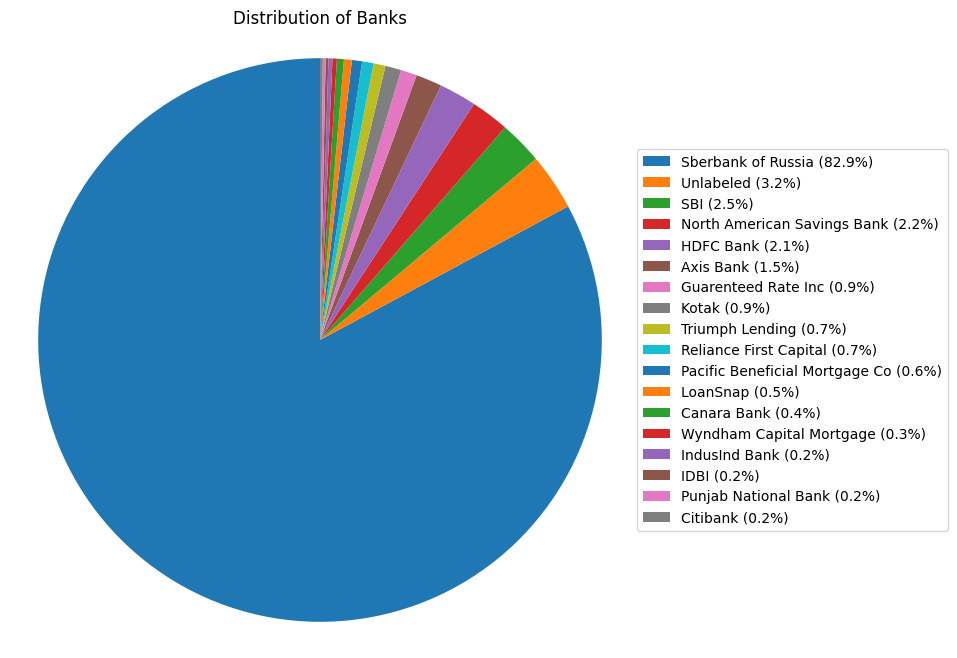

In [42]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'bank' is the column containing bank names
bank_counts = datadf['bank'].value_counts()

# Plotting a pie chart with labels on the side
plt.figure(figsize=(8, 8))
plt.pie(bank_counts, labels=None, autopct='', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Adding a legend on the side with percentages
labels_with_percentages = [f'{label} ({percent:.1f}%)' for label, percent in zip(bank_counts.index, (bank_counts / len(datadf)) * 100)]
plt.legend(labels_with_percentages, loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Distribution of Banks')
plt.show()

<h5>Below we can see the mean of ratings given by the users for each bank that exists in our dataset. We exclude the unlabaled banks from this plot.</h5>

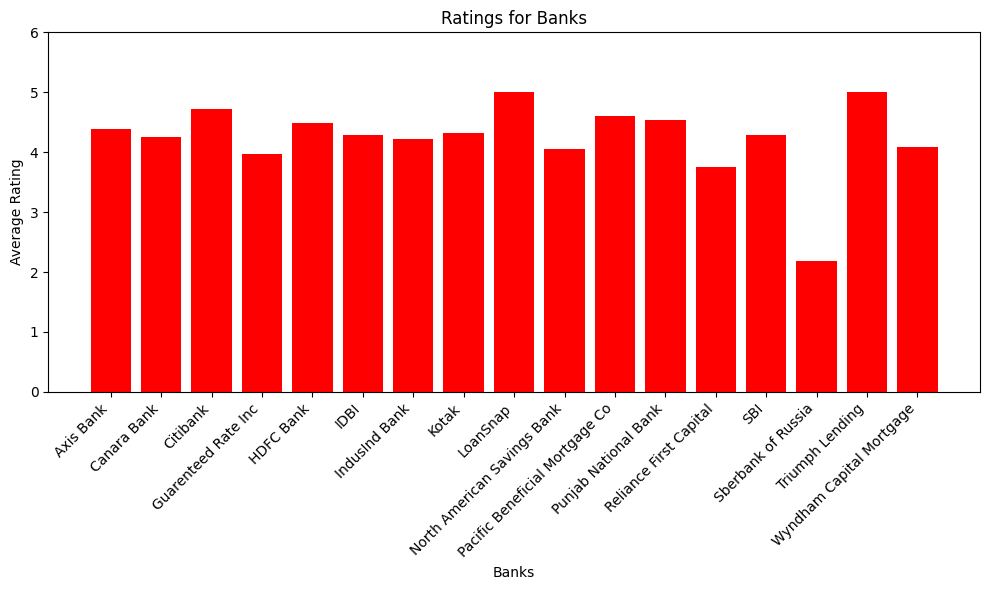

In [43]:
# Group by 'bank' and sum the ratings
filtered_df = datadf[datadf['bank'] != 'Unlabeled']
total_ratings = filtered_df.groupby('bank')['rating'].mean().reset_index()

# Create a bar chart for total ratings
plt.figure(figsize=(10, 6))
plt.bar(total_ratings['bank'], total_ratings['rating'], color='red')
plt.xlabel('Banks')
plt.ylabel('Average Rating')
plt.title('Ratings for Banks')
plt.ylim(0, total_ratings['rating'].max() + 1)  # Set y-axis limit based on the maximum total rating
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

<h5>Now lets see the top areas that the customers are writing bad reviews and complaints about. All banks were included here. The following methods are used to tokenize the content of the reviews, remove the stopwords and find the most common words. The bank names are included in the stop words.</h5>

In [46]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import ngrams
from collections import Counter

bank_names = datadf['bank'].unique().tolist()
bank_names = [bank_name.lower() for bank_name in bank_names]
modified_bank_names = [bank_name.lower().replace('bank', '').strip() for bank_name in bank_names]
bank_names.extend(modified_bank_names)
#print(bank_names)

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    
    #remove bank names from reviews
    words = [word.lower() for word in words if word.lower() not in bank_names]
    filtered_words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]
    return filtered_words
    
datadf['cleaned_review'] = datadf['review'].apply(lambda x: remove_stopwords(x))

# Function to extract n-grams from a list of words
def extract_ngrams(words, n):
    return list(ngrams(words, n))

def top_areas (df, n):
    # Flatten the list of bigrams
    all_bigrams = [bigram for sublist in df['bigrams'] for bigram in sublist]
    # Count the occurrences of each bigram
    bigram_counter = Counter(all_bigrams)
    
    # Print the most common bigrams
    most_common_bigrams = bigram_counter.most_common(n)
    #print("Most common bigrams:")
    #for bigram, count in most_common_bigrams:
    #    print(f"{bigram}: {count}")
   
    most_common_bigrams.reverse()  # Reverse the order
    plt.barh(range(len(most_common_bigrams)), [count for bigram, count in most_common_bigrams], align='center')
    plt.yticks(range(len(most_common_bigrams)), [bigram for bigram, count in most_common_bigrams])
    plt.xlabel('Frequency')
    plt.ylabel('Topics')
    plt.title('Most mentioned topics in Reviews')
    plt.show()


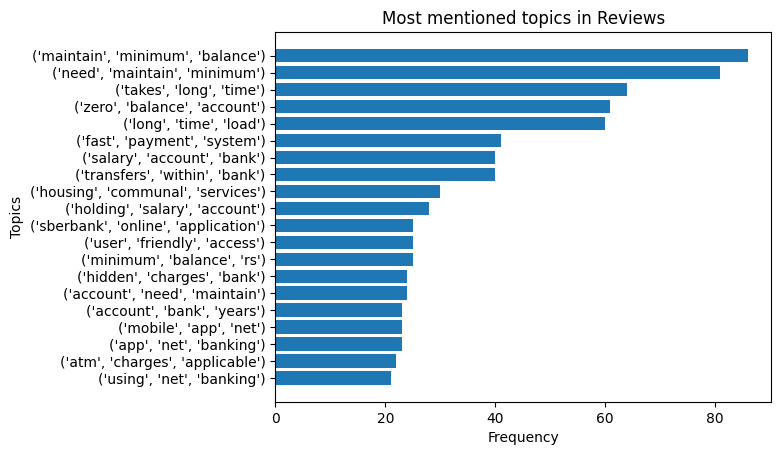

In [47]:
negative_reviews = datadf[datadf['sentiment']=='negative'].copy()
negative_reviews['bigrams'] = negative_reviews['cleaned_review'].apply(lambda x: extract_ngrams(x, 3))
top_areas(negative_reviews,20)

<h5>Looking at the results above seems that the most frequent complaints of customers regarding the bank services of all banks in our database are:<br>
    * Maintaining the minimum balance<br>
    * Long loading time<br>
    * Hidden charges & Other charges (commissions)<br>
    * Usability & Friendly Interface Issues <br>
    * Account Maintenance<br></h5>

<h4>Part 3: Bank Specific Data Analysis</h4>
<h5>Now lets dive into Bank specific analytics. This part aims to show that by analyzing the reviews of a service or an application, we can extract the key-areas that we can dig in to find bugs, issues and other problems that result into bad user experience and low customer satisfaction. For reference we will focus on the banks that we have the most reviews about, which are the following: <br>
- SBI <br>
- Sberbank of Russia <br> <br></h5>

<h4><u>SBI Analysis</u></h4>
<h5>Firstly, lets see the negative reviews for SBI Bank. By looking at the chart below, we see that the most negative reviews are about:<br>
* Maintaining minimum balance<br>
* Alerts <br>
* Hidden charges</h5>

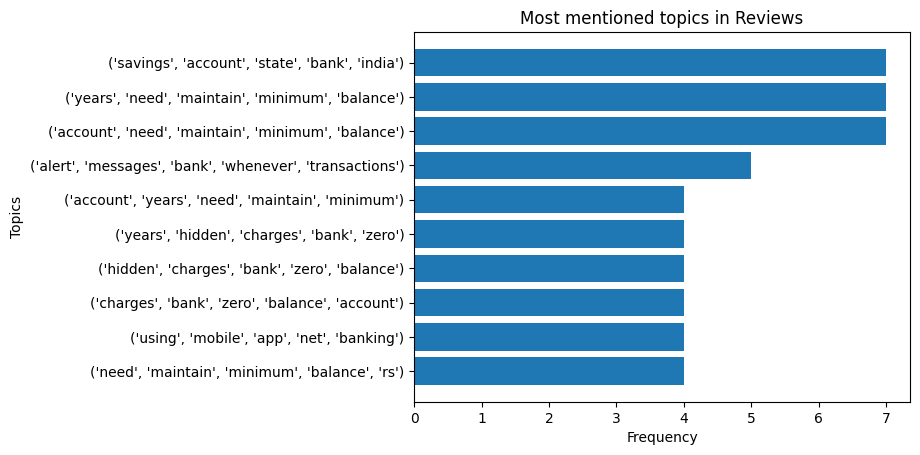

In [48]:
sbiData=datadf[datadf['bank']=='SBI']
negative_reviews = sbiData[sbiData['sentiment']=='negative'].copy()
negative_reviews['bigrams'] = negative_reviews['cleaned_review'].apply(lambda x: extract_ngrams(x, 5))
top_areas(negative_reviews,10)

<h5>Now lets run the same method for the positive revirews to see what are the customers are prasing the bank about. <br>
* Maintain minimum balance <br>
* User friendly bank services <br>
* Well Service/Support</h5>

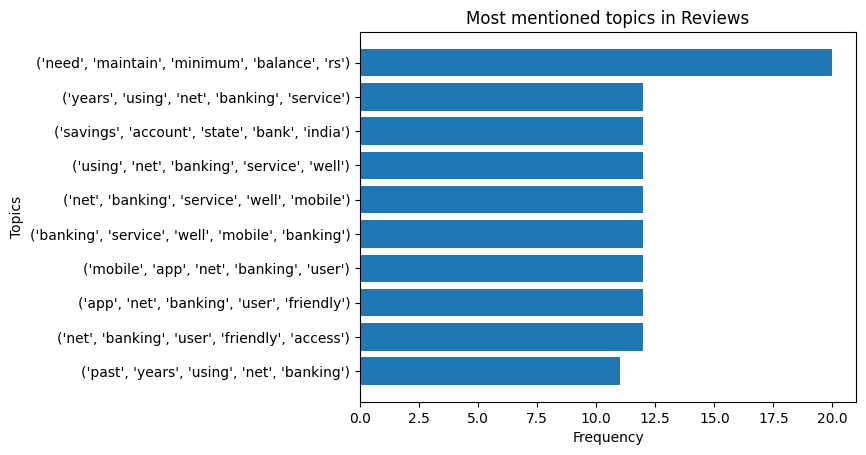

In [49]:
positive_reviews = sbiData[sbiData['sentiment']=='positive'].copy()
positive_reviews['bigrams'] = positive_reviews['cleaned_review'].apply(lambda x: extract_ngrams(x, 5))
top_areas(positive_reviews,10)

<h5>It is interesting to see that some users are happy with maintaining the minimum balance whether some others are complaining for it, concerning the negative reviews above. By having a look at the actual positive reviews below we can see that these reviews are positive or neutral regarding the minimum balance. <br> <br>
The reviews below which are related with the minimum balance, show that the topic-keywords extracted above are ver helpful for the bank to find priorities and which areas to focus during their development. </h5>

In [50]:
for index, row in positive_reviews[['review']].iterrows():
    if 'maintain' in row['review'] and 'balance' in row['review'] and 'minimum' in row['review']:
        print(f"{row['review']}")
        print("-" * 50)  # Separate each review with a line for clarity

When my father taken the housing loan, they have asked me to opened the savings account from SBI. 6 months before, i opened this account. I need to maintain a minimum balance of Rs. 3000. I don't activate the net banking facility and mobile app. When i went to the branch the service was good.
--------------------------------------------------
When I was a student, I had opened the savings account from State Bank of India. I never contacted the customer care for any kind of issues. I have been holding this account for almost 10 years but nowadays I'm not doing any transaction from this account. I need to maintain a minimum balance of Rs. 500. I have not activated online banking facility till now.
--------------------------------------------------
Overall I have been using State Bank account for more than 8 years but for past 1 year, I have been using it as a salary account anyway i need to maintain a minimum balance of Rs. 5,000. Chosen this bank because when i was in native i opened th

<h4><u>Sberbank of Russia Analysis</u></h4>
<h5>Now, lets have a deep look on the Sberbank of Russia. At first, lets see a time-series plot which shows the rating scores given by the users through the years. Observing the plot we can tell that the bank does not performing well in meeting the customer's expectations and it's receiving more and more negative reviews in the past few years. Generally it has a downward trend, except some good rating scores at the begining of 2018 and with a slight up-raise in 2022.  </h5>

In [51]:
sberbankData=datadf[datadf['bank']=='Sberbank of Russia']

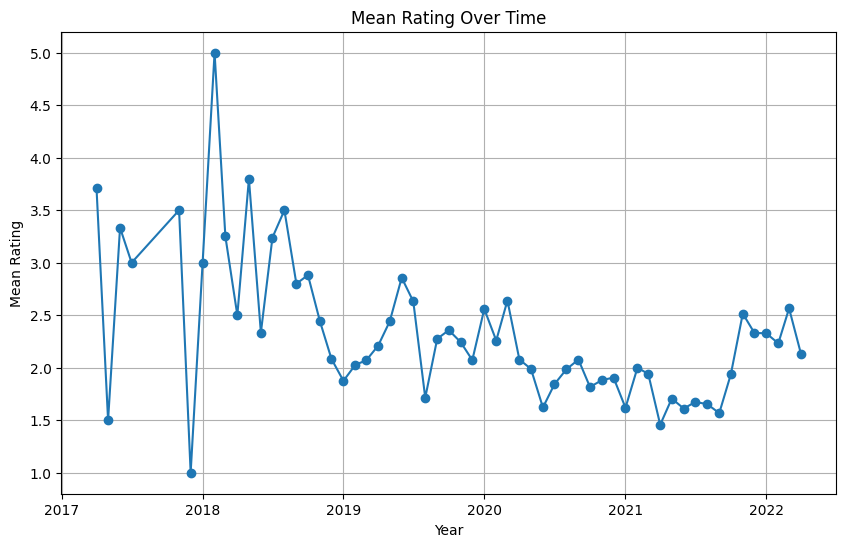

In [52]:
dateData = sberbankData.copy()
dateData['date'] = pd.to_datetime(dateData['date'])
dateData['date'] = dateData['date'].dt.tz_localize(None)
monthly_mean_ratings = dateData.groupby(dateData['date'].dt.to_period("M")).agg({'rating': 'mean'}).reset_index()
monthly_mean_ratings['date'] = monthly_mean_ratings['date'].dt.to_timestamp()

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(monthly_mean_ratings['date'], monthly_mean_ratings['rating'], marker='o', linestyle='-')
plt.title('Mean Rating Over Time')
plt.xlabel('Year')
plt.ylabel('Mean Rating')
plt.grid(True)
plt.show()
      

<h5>Now lets see the negative revies for Sberbank of Russia as we did with SBI bank. By observing the negative reviews below, we can tell that the customers were quite frustrated with the bank! We can extract the following topics as the trendy negative reviews that the bank sould focus on: <br>
* Asking for card details <br>
* Long time to load <br> 
* Updates get worse and worse</h5>

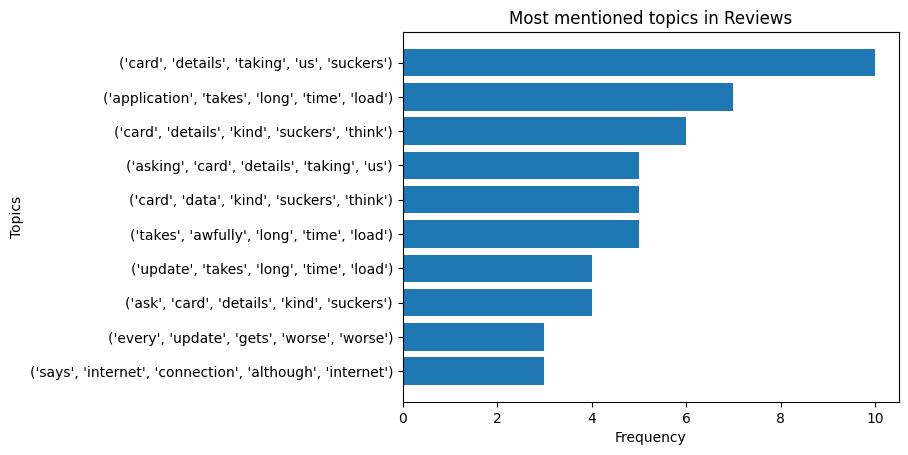

In [53]:
negative_reviews = sberbankData[sberbankData['sentiment']=='negative'].copy()
negative_reviews['bigrams'] = negative_reviews['cleaned_review'].apply(lambda x: extract_ngrams(x, 5))
top_areas(negative_reviews,10)

<h5>The code below shows some negative reviews regarding the card details and verify that customers are frustrated for being required to enter their card details.</h5>

In [54]:
for index, row in negative_reviews[['review']].iterrows():
    if 'card details' in row['review']:
        print(f"{row['review']}")
        print("-" * 50)  # Separate each review with a line for clarity

They are asking for card details. Do you take us for suckers?
--------------------------------------------------
They are asking for card details!!
Why are you taking us for suckers??
--------------------------------------------------
It asks for card details, are you taking people for fools?
--------------------------------------------------
Do you take us for suckers, why do you ask for card details at the entrance?!!!????
--------------------------------------------------
They're asking for card details, are you taking us for suckers?
--------------------------------------------------
They are asking for card details!!! Fraudsters!!
--------------------------------------------------
They are asking for card details, are you taking me for a sucker?
--------------------------------------------------
The application asks for bank card details, don't take us for idiots
--------------------------------------------------
1. When choosing the option to top up a card from another bank, at l

<h5>Now, the positive reviews. The most trendy topics referenced in the positive reviews are the following: <br>
* Suggestions for additions (dark theme, fast payment system) <br>
* Improvements (cards page, loading time) <br>
* Payments </h5>

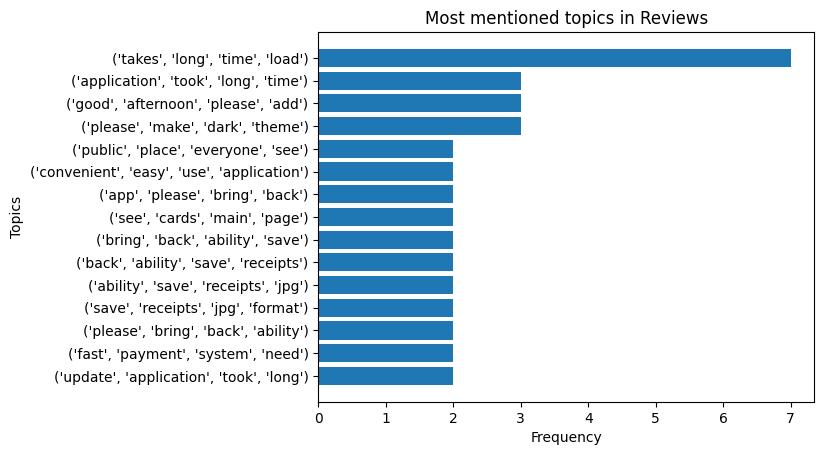

In [55]:
positive_reviews = sberbankData[sberbankData['sentiment']=='positive'].copy()
positive_reviews['bigrams'] = positive_reviews['cleaned_review'].apply(lambda x: extract_ngrams(x, 4))
top_areas(positive_reviews,15)

<h5>By searching for 'add' keyword in the positive reviews, we can see a lot of addition requests by the users and especially for dark theme. </h5>

In [56]:
additionCounter=0 
darkMode=0 
for index, row in positive_reviews[['review']].iterrows():
    if 'add' in row['review']:
        additionCounter=additionCounter+1
        print(f"{row['review']}")
        print("-" * 50)  # Separate each review with a line for clarity

    if 'dark' in row['review']:
        darkMode=darkMode+1


Hello, it would be nice if they added a feature such as choosing whether to accept or reject incoming transfers. Otherwise, God forbid, someone transfers money and then gets caught for a bribe, or they say it’s a foreign agent, try to prove it later.
--------------------------------------------------
The Visa connection does not work; there is an error in the last step after accepting the agreement. Offers to add a card later.
--------------------------------------------------
I don’t like the app update, there’s a lot of unnecessary stuff added
--------------------------------------------------
Everything is fine, we added viewing the payment schedule, well done! Adding the ability to print it would be great!
--------------------------------------------------
The Sber application is very convenient, add the possibility of contactless payment so as not to depend on foreign companies such as Apple
--------------------------------------------------
Very comfortably! There is the possibil

In [57]:
print('Reviews for additions: '+ str(additionCounter))
print('Reviews for dark mode:' + str(darkMode))

Reviews for additions: 82
Reviews for dark mode:14


<h5>Same goes with the suggestions. The code below shows all suggested changes for cards.</h5>

In [58]:
for index, row in positive_reviews[['review']].iterrows():
    if 'card' in row['review'] and 'main' in row['review'] :
        print(f"{row['review']}")
        print("-" * 50)  # Separate each review with a line for clarity

I've been using your app for a long time and I'm happy with it. Be careful with Russian translation and spelling when releasing new versions. I already wrote in ‘Dialogues’ what needs to be corrected, but I see that a new version of the application has been released again without amendments. Your mistakes: 1. In the main settings, the item SHOW BLOCKED, and under it, who has them ‘cards and payment accounts’ is written in small letters, unlike all the parameters; 2. In the settings, the SECURITY item, in which authorization using a fingerprint is indicated as LOGIN BY FINGERPRINT. Where did the Russian language go in this case? Well, or let it be TOUCH ID instead of FINGERPRINT, as is implemented in many applications.
--------------------------------------------------
The application is 10/10, the functionality is excellent, but it would be even better if the ability to hide card amounts on the main screen and open them when you click on a card or account was added. Because it’s not al

<h4>Conclusion </h4>
<h5>This project highlights the importance of bank customer reviews on services or applications offered by the banks and how valuable they can be. Especially in countries where the reviews could be thousands, difficult to be processed manually. Such implementation can extract the topics which are mostly mentioned in the customers reviews along with their sentiment (negative or positive), which are useful in shedding a light on the areas that the bank service is lacking, is having an issue or requires improvments and fixes. <br> <br>
Following these key-areas the bank can perform even deeper analysis on reviews related to these areas and define new requirements for their services. <br><br>
Same logic can be applied in other services as well, where customer review is essential, the customer feedback is text and the customer has a saying and not just a rating number. Such services could be other mobile applications, online courses and products selling.</h5>